In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.transforms import *
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super(ConvolutionalNetwork, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)   # Increase filter numbers
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)  # Additional conv layer
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 14 * 14, 2056)      # Increase size and complexity
        self.fc2 = nn.Linear(2056, 1024)               # Additional fc layer
        self.fc3 = nn.Linear(1024, 512)                # Additional fc layer
        self.fc4 = nn.Linear(512, 102)                 # Output layer for 102 classes
        
        # Dropout layers
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, X):
        # Add more layers with relu activation and max pooling
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)

        # Flatten the output for the fully connected layers
        X = X.view(-1, 256 * 14 * 14)

        # Apply relu activation and dropout to each fc layer
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        X = self.dropout(X)
        X = F.relu(self.fc3(X))
        X = self.dropout(X)
        X = self.fc4(X)  # No activation needed here as nn.CrossEntropyLoss will be applied

        return X


In [26]:
import copy
from torchvision.transforms import ColorJitter, RandomVerticalFlip, RandomAffine, RandomPerspective, GaussianBlur

def update_transform(epoch):
    new_transform = copy.deepcopy(train_transform)
    
    # Basic transformations
    if epoch > 10:
        new_transform.transforms.insert(0, RandomVerticalFlip(p=0.5))
        new_transform.transforms.insert(1, RandomRotation(degrees=15))  # Adjusted rotation
    if epoch > 20:
        new_transform.transforms[1] = RandomRotation(degrees=30)  # Gradual increase in rotation
    
    # Intermediate transformations
    if epoch > 30:
        new_transform.transforms.insert(3, ColorJitter(brightness=0.02, contrast=0.02))  # Gradual color jitter
    if epoch > 40:
        new_transform.transforms.insert(4, RandomAffine(degrees=0, translate=(0.02, 0.02)))  # Gradual affine
    
    # Advanced transformations
    if epoch > 50:
        new_transform.transforms.insert(5, RandomPerspective(distortion_scale=0.1, p=0.1))  # Gradual perspective
    if epoch > 60:
        new_transform.transforms.insert(6, GaussianBlur(kernel_size=(3, 5), sigma=(0.01, 1)))  # Gradual blur
    
    # Sharpness and saturation adjustments
    if epoch > 70:
        new_transform.transforms[3] = ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05)  # Gradual adjustments
    if epoch > 80:
        new_transform.transforms[3] = ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.01)  # Gradual adjustments
    
    # Scaling up color jitter
    if epoch > 90:
        new_transform.transforms[3] = ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02)  # Gradual adjustments
    
    return new_transform

In [27]:
# Define a transform to resize the images and convert them to tensors
transform = Compose([
    Resize((128, 128)),
    ToTensor()
])

# Load the dataset with the defined transform
dataset = datasets.Flowers102(root="/Users/maciek/cnn_data", split='train', download=True, transform=transform)
loader = DataLoader(dataset, batch_size=10, shuffle=False)

# Function to calculate mean and std
def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0

    for (images, _) in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count

    return mean, std

# Calculate mean and std
mean, std = calculate_mean_std(loader)
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.4330, 0.3819, 0.2964])
Std: tensor([0.2555, 0.2056, 0.2175])


In [28]:
train_transform = Compose([
    Resize((128, 128)),
    RandomResizedCrop(size=(112, 112), scale=(0.8, 1.0)),
    ToTensor(),
    Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2555, 0.2056, 0.2175])
])

val_transform = Compose([
    Resize((112, 112)),
    ToTensor(),
    Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2555, 0.2056, 0.2175]),
])

test_transform = Compose([
    Resize((112, 112)),
    ToTensor(),
    Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2555, 0.2056, 0.2175]),
])


In [29]:
    train_data = datasets.Flowers102(root="/Users/maciek/cnn_data", split='train', download=True, transform=train_transform)
    val_data = datasets.Flowers102(root="/Users/maciek/cnn_data", split='val', download=True, transform=val_transform)
    test_data = datasets.Flowers102(root="/Users/maciek/cnn_data", split='test', download=True, transform=test_transform)

In [30]:
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [31]:
for X, y in train_data:
    break

In [32]:
X.shape

torch.Size([3, 112, 112])

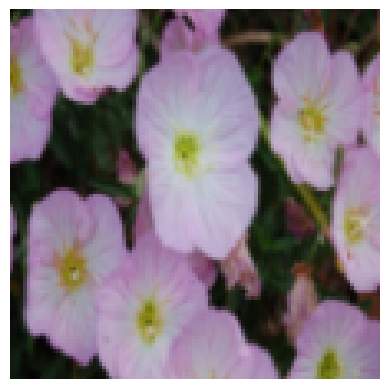

In [33]:
# Assuming X is your image tensor with shape (3, 112, 112)
# Convert the PyTorch tensor to a NumPy array
X_np = X.cpu().detach().numpy()

# Transpose the array to (112, 112, 3) for Matplotlib
X_visual = X_np.transpose(1, 2, 0)

# Denormalize the image
mean = np.array([0.4330, 0.3819, 0.2964])
std = np.array([0.2555, 0.2056, 0.2175])
X_visual = std * X_visual + mean  # This will now work as both are NumPy arrays
X_visual = np.clip(X_visual, 0, 1)  # Ensure values are between 0 and 1

# Visualize the image using Matplotlib
plt.imshow(X_visual)
plt.axis('off')  # Hide the axis
plt.show()


In [34]:
    model = ConvolutionalNetwork()

In [35]:
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

In [36]:
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    model = model.to(device)
    criterion = criterion.to(device)

In [ ]:
import time

start_time = time.time()

# Create Variables To Tracks Things
epochs = 200
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Early Stopping Parameters
patience = 5  # How many epochs to wait after val loss has stopped improving
min_val_loss = float('inf')  # Initialize to infinity
stale_epochs = 0  # Counter for epochs without improvement

# For Loop of Epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Update the train_loader with the new transformations
    current_transform = update_transform(i)  # Get the updated transform for the current epoch
    train_data.transform = current_transform  # Update the transform in the dataset
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)  # Recreate the DataLoader with the updated dataset

    # Train
    for b, (X_train, y_train) in enumerate(train_loader, 1):
        X_train, y_train = X_train.to(device), y_train.to(device)
        y_pred = model(X_train)  # get predicted values from the training set. Not flattened 2D
        loss = criterion(y_pred, y_train)  # how off are we? Compare the predictions to correct answers in y_train

        predicted = torch.max(y_pred.data, 1)[
            1]  # add up the number of correct predictions. Indexed off the first point
        batch_corr = (predicted == y_train).sum()  # how many we got correct from this batch. True = 1, False=0, sum those up
        trn_corr += batch_corr  # keep track as we go along in training.

        # Update our parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

            # Print out some results
        if b % 64 == 0:
            print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Test
    with torch.no_grad():
        val_loss = 0
        for b, (X_test, y_test) in enumerate(val_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
            val_loss += criterion(y_val, y_test).item()  # Sum up the loss from each batch

    avg_val_loss = val_loss / len(val_loader)  # Calculate the average loss
    loss = criterion(y_val, y_test)

    test_losses.append(loss)
    test_correct.append(tst_corr)

    # Early Stopping Check
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        stale_epochs = 0  # Reset the stale epochs counter
    else:
        stale_epochs += 1  # Increment the stale epochs counter
        if stale_epochs >= patience:
            print(f'Stopping early at epoch {i} due to overfitting.')
            break  # Break out of the loop

    print(f'Epoch: {i} Validation Loss: {avg_val_loss}')

current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total / 60} minutes!')


Epoch: 0 Validation Loss: 4.620760500431061
Epoch: 1 Validation Loss: 4.5919189453125
Epoch: 2 Validation Loss: 4.510910779237747
Epoch: 3 Validation Loss: 4.438525214791298
Epoch: 4 Validation Loss: 4.3531777411699295
Epoch: 5 Validation Loss: 4.2619041204452515
Epoch: 6 Validation Loss: 4.169379353523254
Epoch: 7 Validation Loss: 4.152941331267357
Epoch: 8 Validation Loss: 4.030285283923149
Epoch: 9 Validation Loss: 3.993128314614296
Epoch: 10 Validation Loss: 3.8909612745046616
Epoch: 11 Validation Loss: 3.8681368231773376
Epoch: 12 Validation Loss: 3.7706900984048843
Epoch: 13 Validation Loss: 3.766022279858589
Epoch: 14 Validation Loss: 3.7433116734027863
Epoch: 15 Validation Loss: 3.7009797245264053
Epoch: 16 Validation Loss: 3.6501529067754745
Epoch: 17 Validation Loss: 3.6650662273168564
Epoch: 18 Validation Loss: 3.6334057599306107
Epoch: 19 Validation Loss: 3.6288410127162933
Epoch: 20 Validation Loss: 3.5609224140644073
Epoch: 21 Validation Loss: 3.6268606185913086
Epoch: 22

In [ ]:
# Convert GPU tensors to CPU tensors, detach them from the computation graph, and then to NumPy arrays
train_losses = [tl.cpu().detach().numpy() for tl in train_losses]
test_losses = [tl.cpu().detach().numpy() for tl in test_losses]

# Now you can plot using matplotlib
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()
plt.show(block=True)

In [ ]:
test_data

In [ ]:
plt.plot([t.cpu()/10 for t in train_correct], label="Training Accuracy")
plt.plot([t.cpu()/10 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [ ]:
#test_load_everything = DataLoader(test_data, batch_size=6149, shuffle=False)

In [ ]:
from torch.utils.data import DataLoader

# Use a smaller batch size
test_load_everything = DataLoader(test_data, batch_size=1024, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for X_test, y_test in test_load_everything:
        X_test, y_test = X_test.to('mps'), y_test.to('mps')
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum().item()
        total += y_test.size(0)

# Calculate accuracy
accuracy = correct / total
print(f'Accuracy of the model on the test set: {accuracy * 100:.2f}%')

In [ ]:
#with torch.no_grad():
    #correct = 0
    #model.to('mps')  # Ensure the model is on the MPS device
    #for X_test, y_test in test_load_everything:
        #X_test = X_test.to('mps')  # Move X_test to MPS device
        #y_test = y_test.to('mps')  # Move y_test to MPS device as well
        #y_val = model(X_test)
        #predicted = torch.max(y_val, 1)[1]
        #correct += (predicted == y_test).sum()


In [ ]:
#X_test.shape

In [ ]:
#correct.item()/len(test_data)*100

In [ ]:
# Assuming you have a trained model called 'model'
#torch.save(model.state_dict(), 'model_weights.pth')